In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install -q ultralytics pycocotools

In [5]:
import os, cv2, yaml, torch, shutil, random
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Sets paths to your dataset.

train_imgs_dir = "/kaggle/input/car-object-detection/data/training_images"
train_labels_path = "/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"
test_imgs_dir = "/kaggle/input/car-object-detection/data/testing_images"

In [7]:
# Randomize images for train/val split.

imgs_list = sorted(os.listdir(train_imgs_dir))
random.shuffle(imgs_list)


In [8]:
# Creates 80/20 split for training and validation

split_idx = int(0.8 * len(imgs_list))
train_imgs = imgs_list[:split_idx]
val_imgs = imgs_list[split_idx:]

In [9]:
root_dir = "/kaggle/working/data"
labels_dir = f"{root_dir}/labels"
images_dir = f"{root_dir}/images"

for sub in ['train', 'val']:
    os.makedirs(f"{images_dir}/{sub}", exist_ok=True)
    os.makedirs(f"{labels_dir}/{sub}", exist_ok=True)

# Creates folders for YOLO format (images + labels per split)

In [10]:
df = pd.read_csv(train_labels_path)
df.rename(columns={'image': 'img_name'}, inplace=True)
df["class"] = 0


In [11]:
# Image size is fixed in this dataset
width, height = 676, 380

# Normalize coordinates
df["x_centre"] = (df["xmin"] + df["xmax"]) / 2 / width
df["y_centre"] = (df["ymin"] + df["ymax"]) / 2 / height
df["width"] = (df["xmax"] - df["xmin"]) / width
df["height"] = (df["ymax"] - df["ymin"]) / height

df_yolo = df[["img_name", "class", "x_centre", "y_centre", "width", "height"]]

# YOLO format requires normalized center x/y and width/height.

In [12]:
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [13]:
# Copies images and generates .txt label files per image in YOLO format

for img_name in imgs_list:
    subset = "train" if img_name in train_imgs else "val"
    shutil.copy(os.path.join(train_imgs_dir, img_name), os.path.join(images_dir, subset, img_name))

    if img_name in df_yolo["img_name"].values:
        bbox_data = df_yolo[df_yolo["img_name"] == img_name][["class", "x_centre", "y_centre", "width", "height"]].values
        with open(os.path.join(labels_dir, subset, img_name.replace(".jpg", ".txt")), "w") as f:
            for row in bbox_data:
                f.write(" ".join(map(str, row)) + "\n")

In [14]:
# Create yolo.yaml file

yolo_yaml = {
    'path': root_dir,
    'train': f"{images_dir}/train",
    'val': f"{images_dir}/val",
    'nc': 1,
    'names': ['car']
}

with open("/kaggle/working/yolo.yaml", 'w') as f:
    yaml.dump(yolo_yaml, f)

In [15]:
model = YOLO('yolov8m.pt')

model.train(
    data="/kaggle/working/yolo.yaml",
    epochs=100,
    patience=5,
    batch=8,
    lr0=0.0005,
    imgsz=640
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 317MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, p

100%|██████████| 755k/755k [00:00<00:00, 31.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 122MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2161.6±608.0 MB/s, size: 102.0 KB)


train: Scanning /kaggle/working/data/labels/train... 290 images, 510 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<00:00, 2100.31it/s]

train: New cache created: /kaggle/working/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1018.4±804.0 MB/s, size: 101.1 KB)


val: Scanning /kaggle/working/data/labels/val... 65 images, 136 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 1454.11it/s]

val: New cache created: /kaggle/working/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.87G       1.51      1.688       1.42         17        640: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.73it/s]

                   all        201         93     0.0507      0.817     0.0497     0.0269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.62G      1.477      1.098      1.436         12        640: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]

                   all        201         93      0.958       0.86      0.945      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.68G      1.606      1.275      1.559          9        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]

                   all        201         93     0.0607      0.882     0.0605     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.75G      1.558      1.097      1.576          5        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]

                   all        201         93      0.056      0.645     0.0443     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.82G      1.629      1.049      1.586          6        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]

                   all        201         93      0.943      0.898      0.944      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.88G      1.459     0.9776      1.477          8        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.41it/s]

                   all        201         93      0.876      0.968      0.951      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.95G      1.519     0.9568      1.516          3        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.45it/s]

                   all        201         93      0.901      0.989      0.963      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.02G      1.452     0.8759      1.478         11        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]

                   all        201         93      0.986      0.946      0.981      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.08G      1.413     0.8128      1.453          9        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.35it/s]

                   all        201         93      0.899      0.959      0.968      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.83G      1.453     0.8451      1.467         12        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.36it/s]

                   all        201         93      0.936      0.939      0.987      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       5.9G      1.367     0.8054      1.423         14        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.77it/s]

                   all        201         93      0.926      0.939      0.981      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.96G      1.386     0.7622      1.397          5        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]

                   all        201         93      0.956      0.938      0.983      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.03G      1.385     0.8126      1.454          7        640: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.42it/s]

                   all        201         93          1      0.981      0.986       0.66
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.136 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        201         93      0.986      0.946      0.981      0.671
Speed: 0.1ms preprocess, 6.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5ea49f7e10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [16]:
# Measures accuracy of trained model on validation data

model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
metrics = model.val()

print(f"mAP@.5:.95 = {metrics.box.map:.4f}")
print(f"mAP@.50    = {metrics.box.map50:.4f}")
print(f"mAP@.75    = {metrics.box.map75:.4f}")

Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1686.7±557.1 MB/s, size: 80.3 KB)


val: Scanning /kaggle/working/data/labels/val.cache... 65 images, 136 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        201         93      0.986      0.946      0.981      0.673
Speed: 1.0ms preprocess, 6.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val
mAP@.5:.95 = 0.6726
mAP@.50    = 0.9814
mAP@.75    = 0.8351


In [17]:
# Make predictions directory
!mkdir -p /kaggle/working/predictions

results = model.predict(source=test_imgs_dir, conf=0.5, iou=0.75)

test_img_list = []
for result in results:
    if len(result.boxes.xyxy):
        name = os.path.basename(result.path).split('.')[0]
        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        test_img_list.append(name)

        with open(f"/kaggle/working/predictions/{name}.txt", "w") as f:
            for score, box in zip(scores, boxes):
                f.write(f"{score:.4f} {' '.join(map(str, box))}\n")


image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 43.9ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 11.9ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 12.1ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 12.1ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 12.1ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 12.1ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 12.1ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 12.1ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_

In [18]:
def show_bbox(img, boxes, scores, axis, color=(0,255,0)):
    img = img.copy()
    for i, box in enumerate(boxes.astype(int)):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        y = box[1] - 10 if box[1] - 10 > 10 else box[1] + 10
        cv2.putText(img, f"{scores[i]:.2f}", (box[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    axis.imshow(img)
    axis.axis("off")

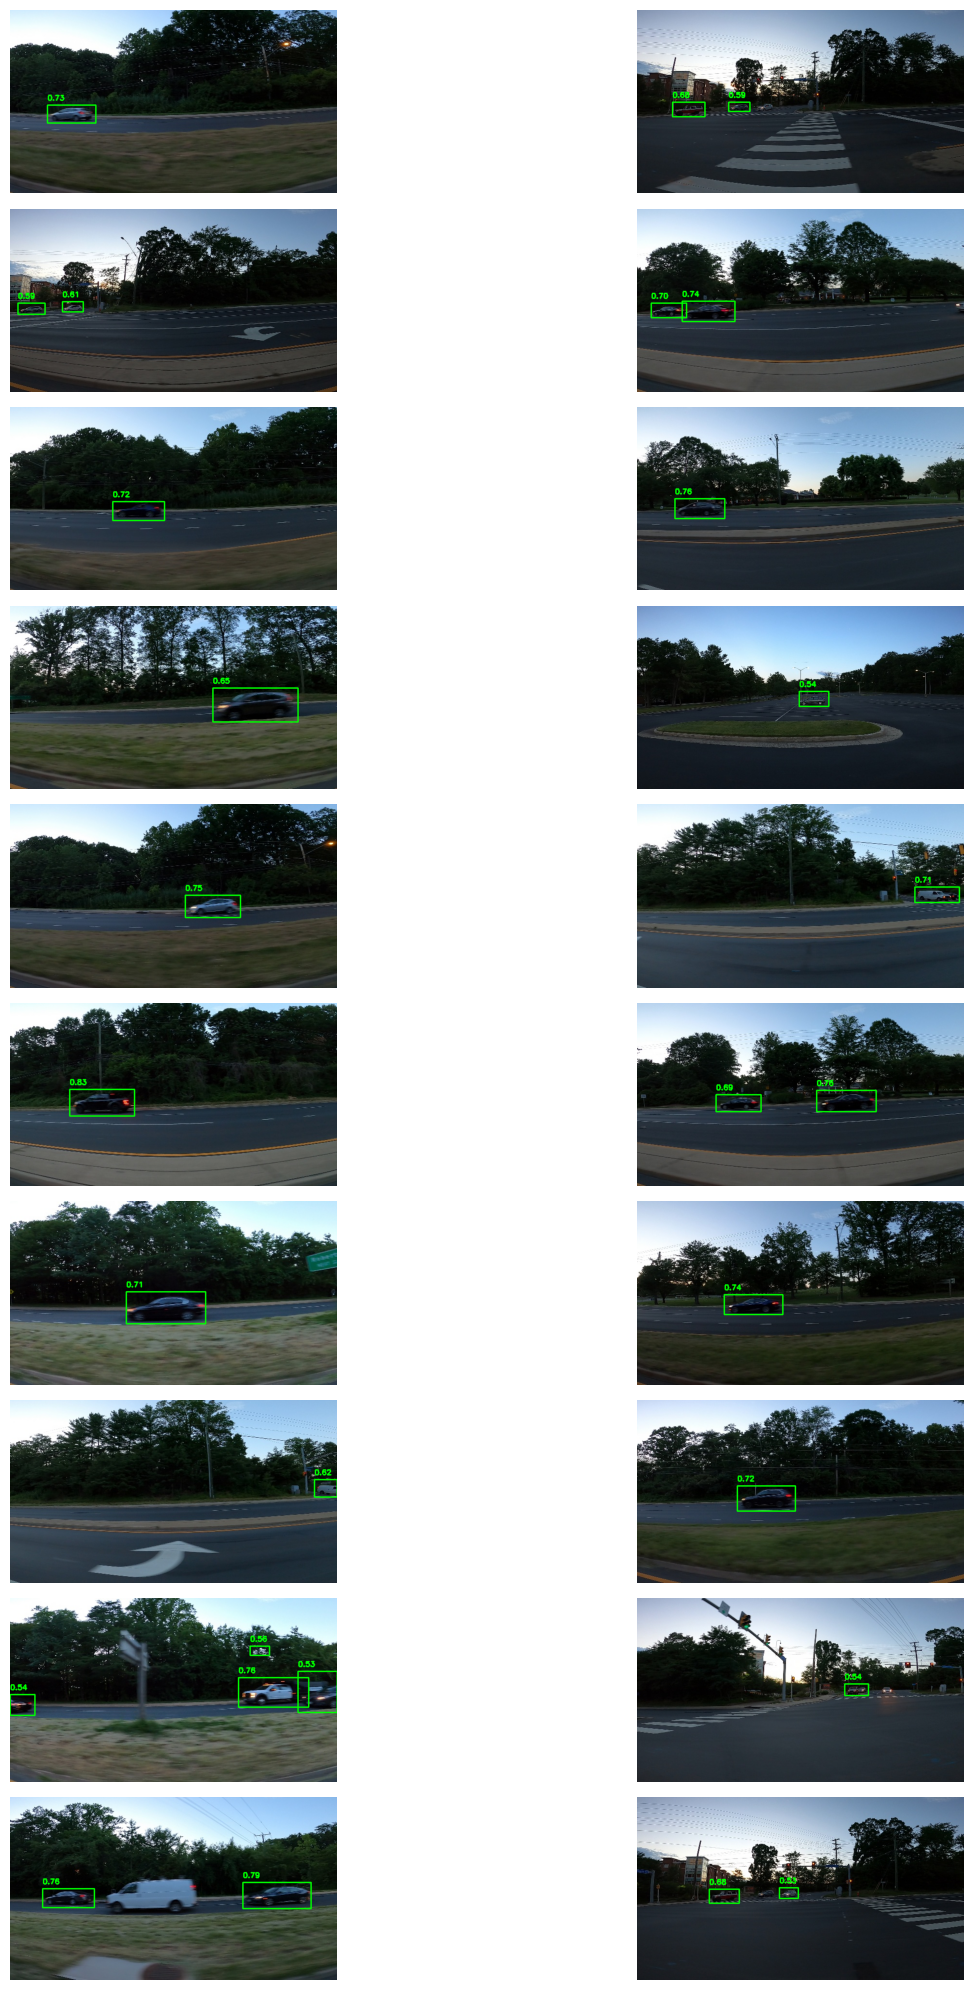

In [19]:
# Plots 20 test images with predicted bounding boxes and confidence scores

fig, axes = plt.subplots(10, 2, figsize=(16, 20))  # 20 images: 10 rows × 2 columns
axes = axes.flatten()

# Pick 20 random images from the test set
sample_imgs = np.random.choice(test_img_list, 20, replace=False)

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(test_imgs_dir, img_name + ".jpg")
    label_path = os.path.join("/kaggle/working/predictions", img_name + ".txt")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if os.path.exists(label_path):  # Ensure label file exists
        label = pd.read_csv(label_path, sep=" ", header=None).values
        show_bbox(img, label[:, 1:], label[:, 0], axes[i])
    else:
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title("No predictions")

plt.tight_layout()
plt.show()

In [22]:
!zip -r /kaggle/working/results.zip /kaggle/working -x "*.zip"

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/data/ (stored 0%)
  adding: kaggle/working/data/images/ (stored 0%)
  adding: kaggle/working/data/images/train/ (stored 0%)
  adding: kaggle/working/data/images/train/vid_4_16900.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_660.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_26260.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_2560.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_13280.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_12360.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_9940.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_8680.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_17560.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_11020.jpg (deflated 0%)
  adding: kaggle/working/data/images/train/vid_4_17360.jpg (deflated 0%)
  adding: kaggl

## DOWNLOAD

In [20]:
with open("/kaggle/working/yolo11n.pt", "w") as f:
    f.write("yolo11n.pt")

In [21]:
with open("/kaggle/working/yolov8m.pt", "w") as f:
    f.write("yolov8m.p")

## Inference


0: 384x640 1 car, 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


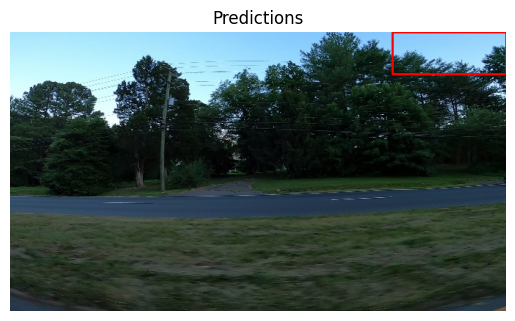

In [30]:
# Load model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")




0: 384x640 1 car, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


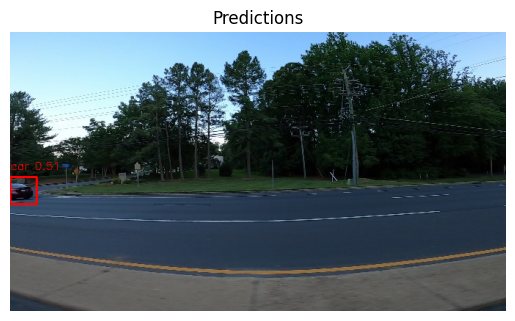

In [34]:
# Read image
img = cv2.imread('/kaggle/working/data/images/val/vid_4_10520.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct color display

# Run inference
results = model.predict(img,conf=0.5)[0]
boxes = results.boxes

# Draw boxes
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy()[0])
    conf = box.conf.cpu().numpy()[0]
    cls = int(box.cls.cpu().numpy()[0])
    label = f"{results.names[cls]} {conf:.2f}"  # get class name and confidence

    # Draw rectangle and label
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 1)

# Show image with matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Predictions")
plt.show()


0: 384x640 (no detections), 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


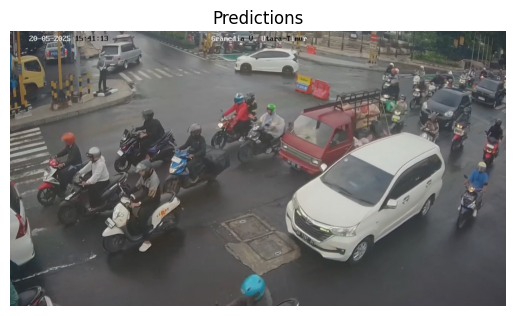

In [41]:
# Read image
img = cv2.imread('/kaggle/input/test-data-video/Screenshot 2025-06-09 at 3.02.53PM.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct color display

# Run inference
results = model.predict(img,conf=0.08)[0]
boxes = results.boxes

# Draw boxes
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy()[0])
    conf = box.conf.cpu().numpy()[0]
    cls = int(box.cls.cpu().numpy()[0])
    label = f"{results.names[cls]} {conf:.2f}"  # get class name and confidence

    # Draw rectangle and label
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 1)

# Show image with matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Predictions")
plt.show()